In [2]:
### !pip install darts optuna pytorch-lightning holidays --quiet
!pip install ipywidgets jupyterlab-widgets
!jupyter nbextension enable --py widgetsnbextension
import torch


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import holidays
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from pytorch_lightning.callbacks import Callback
from darts.metrics import mae, rmse, mape
from darts.models import TFTModel, NaiveSeasonal
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
import gc
import datetime
import json
import sys

warnings.filterwarnings('ignore')

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [5]:
df = pd.read_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/alldata.csv')

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

print(f"Loaded {len(df)} hours of data")
print(f"From: {df['datetime'].min()}")
print(f"To:   {df['datetime'].max()}")
print(f"Columns: {df.shape[1]}")

Loaded 65785 hours of data
From: 2018-01-01 00:00:00
To:   2025-07-04 00:00:00
Columns: 32


In [6]:
for lag in [1, 2, 3, 6, 12, 24, 48, 168]:
    df[f'price_lag{lag}'] = df['price'].shift(lag)


df['price_diff_1h'] = df['price'] - df['price'].shift(1)
df['price_diff_24h'] = df['price'] - df['price'].shift(24)
df['price_diff_168h'] = df['price'] - df['price'].shift(168)


for window in [6, 12, 24, 48, 168]:
    df[f'price_mean_{window}h'] = df['price'].rolling(window).mean()
    df[f'price_std_{window}h'] = df['price'].rolling(window).std()
    df[f'price_min_{window}h'] = df['price'].rolling(window).min()
    df[f'price_max_{window}h'] = df['price'].rolling(window).max()

df['price_volatility_24h'] = df['price_std_24h'] / (df['price_mean_24h'] + 1e-6)
df['price_volatility_168h'] = df['price_std_168h'] / (df['price_mean_168h'] + 1e-6)


df['residual_load_forecast'] = df['load_forecast'] - (
    df['solar_forecast'] + 
    df['wind_onshore_forecast'] + 
    df['wind_offshore_forecast']
)

df['gen_nuclear_proxy'] = df['gen_nuclear'].shift(24)
df['gen_hydro_proxy'] = df['gen_hydro_river'].shift(24)

df['thermal_gap_forecast'] = df['residual_load_forecast'] - (
    df['gen_nuclear_proxy'] + df['gen_hydro_proxy']
)



df['renewable_penetration'] = (
    (df['solar_forecast'] + df['wind_onshore_forecast'] + df['wind_offshore_forecast']) 
    / (df['load_forecast'] + 1e-6)
)
df['renewable_penetration_squared'] = df['renewable_penetration'] ** 2
df['thermal_margin'] = df['thermal_gap_forecast'] / (df['load_forecast'] + 1e-6)



df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


df['is_peak'] = ((df['hour'] >= 8) & (df['hour'] <= 20)).astype(int)
df['is_super_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)
df['is_night'] = ((df['hour'] >= 23) | (df['hour'] <= 6)).astype(int)


df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['is_weekend_peak'] = (
    (df['dayofweek'] >= 5) & (df['hour'] >= 10) & (df['hour'] <= 22)
).astype(int)


be_holidays = holidays.BE()
df['is_holiday'] = df['datetime'].apply(lambda x: x in be_holidays).astype(int)



df = df.bfill().ffill()

In [7]:
df['dayofyear'] = df['datetime'].dt.dayofyear
df['dayofmonth'] = df['datetime'].dt.day
df['weekofyear'] = df['datetime'].dt.isocalendar().week


# Momentum indicators
df['price_momentum_24h'] = df['price'] - df['price'].shift(24)
df['price_momentum_168h'] = df['price'] - df['price'].shift(168)
df['price_acceleration_24h'] = df['price_momentum_24h'] - df['price_momentum_24h'].shift(24)

# Volatility clustering (GARCH-like)
for window in [24, 48, 168]:
    rolling_std = df['price'].rolling(window).std()
    df[f'price_vol_regime_{window}h'] = (
        rolling_std / (df['price'].rolling(window*2).std() + 1e-6)
    )

# Price regime indicators (high/medium/low)
rolling_mean = df['price'].rolling(168).mean()
rolling_std = df['price'].rolling(168).std()
df['price_regime'] = 0  # Normal
df.loc[df['price'] > rolling_mean + rolling_std, 'price_regime'] = 1  # High
df.loc[df['price'] < rolling_mean - rolling_std, 'price_regime'] = -1  # Low

# Skewness and kurtosis (detect spikes)
df['price_skew_168h'] = df['price'].rolling(168).skew()
df['price_kurt_168h'] = df['price'].rolling(168).kurt()


# Total renewable
df['total_renewable_forecast'] = (
    df['solar_forecast'] + 
    df['wind_onshore_forecast'] + 
    df['wind_offshore_forecast']
)

# Renewable ratio
df['renewable_ratio'] = df['total_renewable_forecast'] / (df['load_forecast'] + 1e-6)

# Net load (load minus renewables)
df['net_load_forecast'] = df['load_forecast'] - df['total_renewable_forecast']

# Stress index (quand résidual load est élevé vs capacité)
df['grid_stress'] = df['residual_load_forecast'] / (df['load_forecast'] + 1e-6)

# Wind+Solar together (correlation effects)
df['wind_solar_total'] = df['wind_onshore_forecast'] + df['wind_offshore_forecast']
df['wind_solar_ratio'] = (
    df['wind_solar_total'] / (df['total_renewable_forecast'] + 1e-6)
)


df['season_progress'] = (df['dayofyear'] % 91) / 91

# Working day patterns
df['is_working_hour'] = (
    (df['dayofweek'] < 5) & 
    (df['hour'] >= 8) & 
    (df['hour'] <= 18)
).astype(int)

df['is_weekend_evening'] = (
    (df['dayofweek'] >= 5) & 
    (df['hour'] >= 18) & 
    (df['hour'] <= 23)
).astype(int)

# Distance to peak hours
peak_hour = 19
df['distance_to_peak'] = np.minimum(
    np.abs(df['hour'] - peak_hour),
    24 - np.abs(df['hour'] - peak_hour)
)


# Cross features

df['price_lag24_x_renewable'] = df['price_lag24'] * df['renewable_ratio']
df['price_lag168_x_renewable'] = df['price_lag168'] * df['renewable_ratio']

df['price_lag24_x_load'] = df['price_lag24'] * (df['load_forecast'] / 1000)
df['price_lag168_x_load'] = df['price_lag168'] * (df['load_forecast'] / 1000)


df['volatility_x_hour'] = df['price_volatility_24h'] * df['hour']


df['stress_x_peak'] = df['grid_stress'] * df['is_peak']


df = df.bfill().ffill()

print(len(df.columns))
print(df.columns.tolist())

111
['Unnamed: 0', 'datetime', 'price', 'total_gen_forecast', 'total_gen_actual', 'wind_onshore_forecast', 'wind_onshore_actual', 'wind_offshore_forecast', 'wind_offshore_actual', 'solar_forecast', 'solar_actual', 'load_actual', 'load_forecast', 'gen_biomass', 'gen_gas', 'gen_hydro_river', 'gen_nuclear', 'gen_other', 'gen_solar_actual', 'gen_waste', 'year', 'forecast_error', 'wind_onshore_error', 'wind_offshore_error', 'load_error', 'hour', 'month', 'renewable_share', 'renewable_quartile', 'dayofweek', 'price_diff', 'price_lag24', 'price_lag1', 'price_lag2', 'price_lag3', 'price_lag6', 'price_lag12', 'price_lag48', 'price_lag168', 'price_diff_1h', 'price_diff_24h', 'price_diff_168h', 'price_mean_6h', 'price_std_6h', 'price_min_6h', 'price_max_6h', 'price_mean_12h', 'price_std_12h', 'price_min_12h', 'price_max_12h', 'price_mean_24h', 'price_std_24h', 'price_min_24h', 'price_max_24h', 'price_mean_48h', 'price_std_48h', 'price_min_48h', 'price_max_48h', 'price_mean_168h', 'price_std_168h'

In [8]:
past_cols_extended = [

    'price_lag1', 'price_lag2', 'price_lag3', 'price_lag6',
    'price_lag12', 'price_lag24', 'price_lag48', 'price_lag168',
    'price_diff_1h', 'price_diff_24h', 'price_diff_168h',
    'price_momentum_24h', 'price_momentum_168h', 'price_acceleration_24h',
    'price_mean_24h', 'price_mean_48h', 'price_mean_168h',
    'price_std_24h', 'price_std_48h', 'price_std_168h',
    'price_min_24h', 'price_max_24h',
    'price_volatility_24h', 'price_volatility_168h',
    'price_vol_regime_24h', 'price_vol_regime_48h', 'price_vol_regime_168h',
    'price_regime', 'price_skew_168h', 'price_kurt_168h',
    'price_lag24_x_renewable', 'price_lag168_x_renewable',
    'price_lag24_x_load', 'price_lag168_x_load',
    'volatility_x_hour',
]

future_cols_extended = [
    'thermal_gap_forecast', 'residual_load_forecast',
    'load_forecast', 'solar_forecast',
    'wind_onshore_forecast', 'wind_offshore_forecast',
    'total_renewable_forecast', 'renewable_ratio',
    'net_load_forecast', 'grid_stress',
    'wind_solar_total', 'wind_solar_ratio',
    'renewable_penetration', 'renewable_penetration_squared',
    'thermal_margin', 'stress_x_peak',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'month_sin', 'month_cos', 'season_progress',
    'is_peak', 'is_super_peak', 'is_night',
    'is_weekend', 'is_weekend_peak', 'is_weekend_evening',
    'is_holiday', 'is_working_hour',
    'distance_to_peak',
]


print(f"past : {len(past_cols_extended)}")
print(f"future : {len(future_cols_extended)}")

past : 35
future : 32


In [9]:
target_col = 'price'

train_end = pd.Timestamp('2019-06-01')
val_end = pd.Timestamp('2020-03-01')
# test -> after that

ts_target = TimeSeries.from_dataframe(
    df, time_col='datetime', value_cols=target_col, freq='h'
).astype(np.float32)

ts_past = TimeSeries.from_dataframe(
    df, time_col='datetime', value_cols=past_cols_extended, freq='h'
).astype(np.float32)

ts_future = TimeSeries.from_dataframe(
    df, time_col='datetime', value_cols=future_cols_extended, freq='h'
).astype(np.float32)

#arcsinh for spikes
ts_target_asinh = ts_target.map(np.arcsinh)

train_target_for_fit, _ = ts_target_asinh.split_before(train_end)
train_past_for_fit, _ = ts_past.split_before(train_end)
train_future_for_fit, _ = ts_future.split_before(train_end)

scaler_target = Scaler(StandardScaler())
scaler_past = Scaler(StandardScaler())
scaler_future = Scaler(StandardScaler())

scaler_target.fit(train_target_for_fit)
scaler_past.fit(train_past_for_fit)
scaler_future.fit(train_future_for_fit)


ts_target_scaled = scaler_target.transform(ts_target_asinh)
ts_past_scaled = scaler_past.transform(ts_past)
ts_future_scaled = scaler_future.transform(ts_future)



train_series = ts_target_scaled.slice(
    ts_target_scaled.start_time(), 
    train_end - pd.Timedelta(hours=1)
)
val_series = ts_target_scaled.slice(
    train_end, 
    val_end - pd.Timedelta(hours=1)
)
test_end = pd.Timestamp('2021-01-01')
test_series = ts_target_scaled.slice(
    val_end, 
    test_end - pd.Timedelta(hours=1)
)

print(f"Train: {len(train_series):,} hrs ({train_series.start_time()} → {train_series.end_time()})")
print(f"Val:   {len(val_series):,} hrs ({val_series.start_time()} → {val_series.end_time()})")
print(f"Test:  {len(test_series):,} hrs ({test_series.start_time()} → {test_series.end_time()})")

Train: 12,384 hrs (2018-01-01 00:00:00 → 2019-05-31 23:00:00)
Val:   6,576 hrs (2019-06-01 00:00:00 → 2020-02-29 23:00:00)
Test:  7,344 hrs (2020-03-01 00:00:00 → 2020-12-31 23:00:00)


In [8]:
#to prune trials when training
class OptunaPruningCallback(Callback):
    def __init__(self, trial, monitor="val_loss"):
        super().__init__()
        self.trial = trial
        self.monitor = monitor
        
    def on_validation_end(self, trainer, pl_module):
        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            return
        epoch = trainer.current_epoch
        self.trial.report(float(current_score), epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()


def create_objective(train_series, val_series_short, ts_past_scaled, ts_future_scaled):
    
    def objective(trial):
        input_chunk_length = trial.suggest_categorical('input_chunk_length', [168, 336, 504])
        hidden_size = trial.suggest_categorical('hidden_size', [32, 64])
        lstm_layers = trial.suggest_int('lstm_layers', 1, 3)
        num_attention_heads = trial.suggest_categorical('num_attention_heads', [2, 4, 8])
        dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.05)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        hidden_continuous_size_ratio = trial.suggest_categorical(
            'hidden_continuous_size_ratio', 
            [0.125, 0.25, 0.5]
        )
        hidden_continuous_size = int(hidden_size * hidden_continuous_size_ratio)

        pruning_callback = OptunaPruningCallback(trial, monitor="val_loss")
        early_stop = EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)
        
        try:
            model = TFTModel(
                input_chunk_length=input_chunk_length,
                output_chunk_length=24,
                hidden_size=hidden_size,
                hidden_continuous_size=hidden_continuous_size,
                lstm_layers=lstm_layers,
                num_attention_heads=num_attention_heads,
                dropout=dropout,
                batch_size=batch_size,
                n_epochs=10, 
                add_relative_index=True,
                optimizer_kwargs={"lr": lr, "weight_decay": 1e-5},
                loss_fn=torch.nn.HuberLoss(),
                random_state=42,
                force_reset=True,
                save_checkpoints=False,
                pl_trainer_kwargs={
                    "accelerator": "gpu",
                    "devices": 1,
                    "enable_progress_bar": True,
                    "callbacks": [early_stop, pruning_callback],
                    "gradient_clip_val": 1.0,
                    "enable_model_summary": False,
                }
            )
            
            model.fit(
                series=train_series,
                past_covariates=ts_past_scaled,
                future_covariates=ts_future_scaled,
                val_series=val_series_short,
                val_past_covariates=ts_past_scaled,
                val_future_covariates=ts_future_scaled,
            )
            

            preds = model.predict(
                n=24,
                series=train_series,
                past_covariates=ts_past_scaled,
                future_covariates=ts_future_scaled,
                num_samples=1
            )

            pred_original = scaler_target.inverse_transform(preds).map(np.sinh)
            actual_original = scaler_target.inverse_transform(
                val_series_short[:24]
            ).map(np.sinh)
            
            score = float(mae(actual_original, pred_original))

            del model
            torch.cuda.empty_cache()
            gc.collect()
            
            return score
            
        except Exception as e:
            print(f"Trial failed: {e}")
            raise optuna.TrialPruned()
    
    return objective

val_series_short = val_series[:2400]

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42, n_startup_trials=10),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

objective = create_objective(train_series, val_series_short, ts_past_scaled, ts_future_scaled)

study.optimize(
    objective,
    n_trials=10,  
    timeout=48*3600,  
    gc_after_trial=True,
    show_progress_bar=True
)

print("Best results :")

print(f"mae: {study.best_value:.2f} EUR/MWh")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2025-11-29 09:50:11,789] A new study created in memory with name: no-name-9431c27d-0869-4380-bef0-24fda23d08a8


  0%|          | 0/10 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 09:52:27,511] Trial 0 finished with value: 5.917926788330078 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 4, 'dropout': 0.30000000000000004, 'lr': 0.00010838581269344756, 'batch_size': 32, 'hidden_continuous_size_ratio': 1.0}. Best is trial 0 with value: 5.917926788330078.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 10:09:19,643] Trial 1 finished with value: 8.856719017028809 and parameters: {'input_chunk_length': 504, 'hidden_size': 64, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.25, 'lr': 0.0010150667045928574, 'batch_size': 64, 'hidden_continuous_size_ratio': 0.75}. Best is trial 0 with value: 5.917926788330078.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 10:20:11,960] Trial 2 finished with value: 8.936065673828125 and parameters: {'input_chunk_length': 504, 'hidden_size': 32, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.30000000000000004, 'lr': 0.00033852267834519784, 'batch_size': 64, 'hidden_continuous_size_ratio': 0.25}. Best is trial 0 with value: 5.917926788330078.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 10:27:39,993] Trial 3 finished with value: 5.533302307128906 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 8, 'dropout': 0.2, 'lr': 0.00030012301808980484, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.5}. Best is trial 3 with value: 5.533302307128906.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: name 'exit' is not defined
[I 2025-11-29 10:32:38,644] Trial 4 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 10:46:56,610] Trial 5 finished with value: 5.451511859893799 and parameters: {'input_chunk_length': 504, 'hidden_size': 64, 'lstm_layers': 2, 'num_attention_heads': 2, 'dropout': 0.1, 'lr': 0.00011308297976636003, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.25}. Best is trial 5 with value: 5.451511859893799.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: 
[I 2025-11-29 10:48:24,970] Trial 6 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: 
[I 2025-11-29 10:55:51,793] Trial 7 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: name 'exit' is not defined
[I 2025-11-29 10:56:40,728] Trial 8 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


Trial failed: name 'exit' is not defined
[I 2025-11-29 10:56:41,582] Trial 9 pruned. 
Best results :
mae: 5.45 EUR/MWh
input_chunk_length: 504
hidden_size: 64
lstm_layers: 2
num_attention_heads: 2
dropout: 0.1
lr: 0.00011308297976636003
batch_size: 32
hidden_continuous_size_ratio: 0.25


In [9]:
best = study.best_params

final_model = TFTModel(
    input_chunk_length=best['input_chunk_length'],
    output_chunk_length=24,
    hidden_size=best['hidden_size'],
    hidden_continuous_size=16,
    lstm_layers=best['lstm_layers'],
    num_attention_heads=best['num_attention_heads'],
    dropout=best['dropout'],
    batch_size=best['batch_size'],
    n_epochs=50,  
    add_relative_index=True,
    optimizer_kwargs={"lr": best['lr'], "weight_decay": 1e-5},
    loss_fn=torch.nn.HuberLoss(),
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    model_name="tft_final_optimized",
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "enable_progress_bar": True,
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0001)],
        "gradient_clip_val": 1.0,
    }
)

final_model.fit(
    series=train_series,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    val_series=val_series,
    val_past_covariates=ts_past_scaled,
    val_future_covariates=ts_future_scaled,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=2, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=16, categorical_embedding_sizes=None, add_relative_index=True, skip_interpolation=False, loss_fn=HuberLoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=504, output_chunk_length=24, batch_size=32, n_epochs=50, optimizer_kwargs={'lr': 0.00011308297976636003, 'weight_decay': 1e-05}, random_state=42, force_reset=True, save_checkpoints=True, model_name=tft_final_optimized, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'enable_progress_bar': True, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x70011e7d4130>], 'gradient_clip_val': 1.0})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/284 [00:00<?, ?it/s]

mae : 9.83
rmse : 12.82


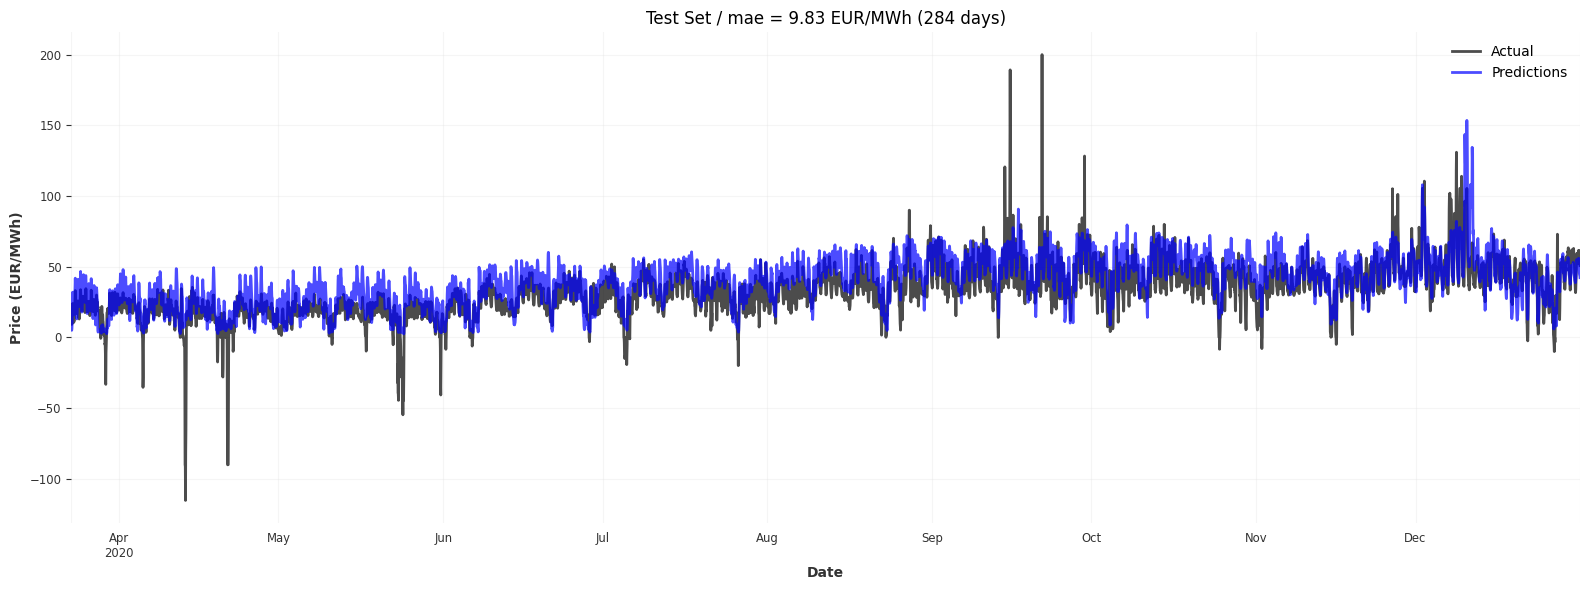

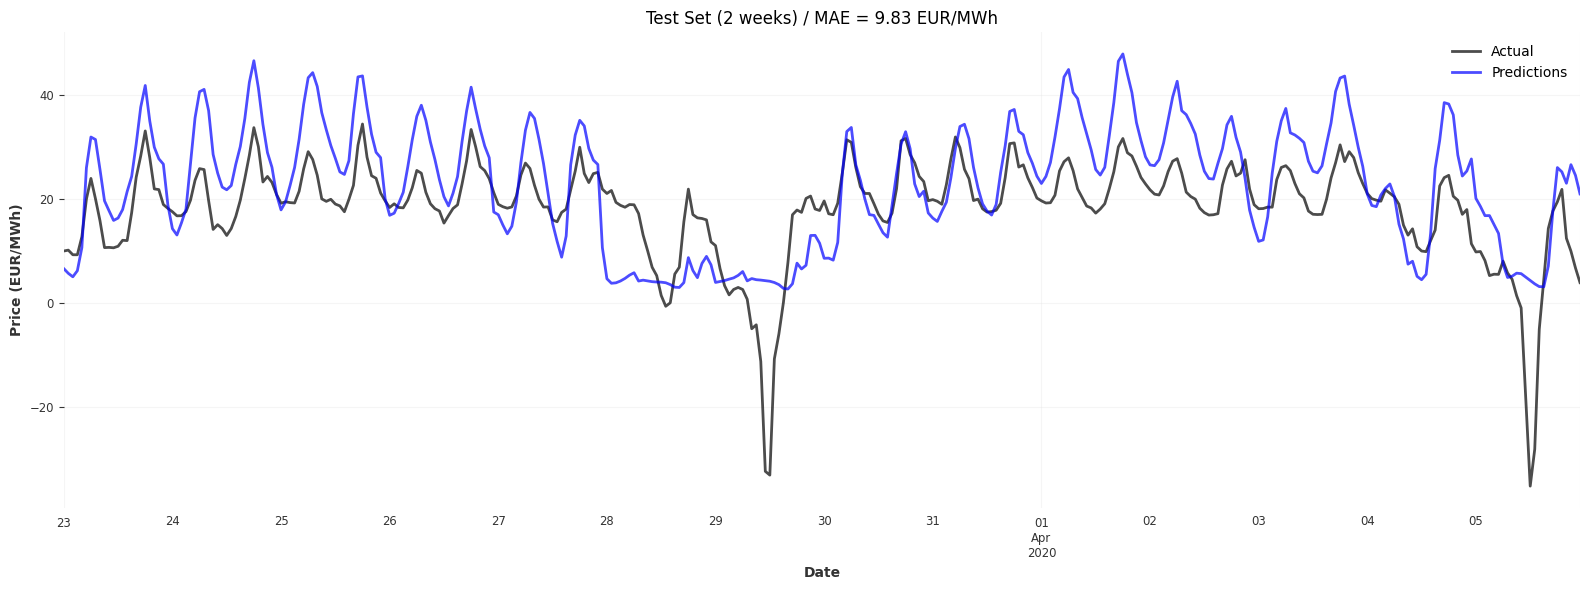

In [10]:
test_preds = final_model.historical_forecasts(
    series=test_series,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    start=best['input_chunk_length'] + 24,
    forecast_horizon=24,
    stride=24,
    retrain=False,
    verbose=True,
    last_points_only=False,
)

all_test_preds = concatenate(test_preds, axis=0)

pred_original = scaler_target.inverse_transform(all_test_preds).map(np.sinh)
actual_slice = test_series.slice(all_test_preds.start_time(), all_test_preds.end_time())
actual_original = scaler_target.inverse_transform(actual_slice).map(np.sinh)

n_days = len(test_preds)
mae_score = float(mae(actual_original, pred_original))
rmse_score = float(rmse(actual_original, pred_original))

print(f"mae : {mae_score:.2f}")
print(f"rmse : {rmse_score:.2f}")

plt.figure(figsize=(16, 6))
actual_original.plot(label="Actual", color="black", alpha=0.7)
pred_original.plot(label="Predictions", color="blue", alpha=0.7)
plt.title(f"Test Set / mae = {mae_score:.2f} EUR/MWh ({n_days} days)")
plt.ylabel("Price (EUR/MWh)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
actual_original[:336].plot(label="Actual", color="black", alpha=0.7)
pred_original[:336].plot(label="Predictions", color="blue", alpha=0.7)
plt.title(f"Test Set (2 weeks) / MAE = {mae_score:.2f} EUR/MWh")
plt.ylabel("Price (EUR/MWh)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
class OptunaPruningCallback(Callback):
    def __init__(self, trial, monitor="val_loss"):
        super().__init__()
        self.trial = trial
        self.monitor = monitor
        
    def on_validation_end(self, trainer, pl_module):
        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            return
        epoch = trainer.current_epoch
        self.trial.report(float(current_score), epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()
            
def create_objectivebis(train_series, val_series_short, ts_past_scaled, ts_future_scaled):
    
    def objective(trial):
        input_chunk_length = trial.suggest_categorical('input_chunk_length', [168, 336, 504])
        hidden_size = trial.suggest_categorical('hidden_size', [32, 64])
        lstm_layers = trial.suggest_int('lstm_layers', 1, 3)
        num_attention_heads = trial.suggest_categorical('num_attention_heads', [2, 4, 8])
        dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.05)
        lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        hidden_continuous_size_ratio = trial.suggest_categorical(
            'hidden_continuous_size_ratio', 
            [0.125, 0.25, 0.5]
        )
        hidden_continuous_size = int(hidden_size * hidden_continuous_size_ratio)

        pruning_callback = OptunaPruningCallback(trial, monitor="val_loss")
        early_stop = EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)
        
        try:
            model = TFTModel(
                input_chunk_length=input_chunk_length,
                output_chunk_length=24,
                hidden_size=hidden_size,
                hidden_continuous_size=hidden_continuous_size,
                lstm_layers=lstm_layers,
                num_attention_heads=num_attention_heads,
                dropout=dropout,
                batch_size=batch_size,
                n_epochs=10, 
                add_relative_index=True,
                optimizer_kwargs={"lr": lr, "weight_decay": 1e-5},
                loss_fn=torch.nn.HuberLoss(),
                random_state=42,
                force_reset=True,
                save_checkpoints=False,
                pl_trainer_kwargs={
                    "accelerator": "gpu",
                    "devices": 1,
                    "enable_progress_bar": True,
                    "callbacks": [early_stop, pruning_callback],
                    "gradient_clip_val": 1.0,
                    "enable_model_summary": False,
                }
            )
            
            model.fit(
                series=train_series,
                past_covariates=ts_past_scaled,
                future_covariates=ts_future_scaled,
                val_series=val_series_short,
                val_past_covariates=ts_past_scaled,
                val_future_covariates=ts_future_scaled,
            )
            

            preds = model.predict(
                n=24,
                series=train_series,
                past_covariates=ts_past_scaled,
                future_covariates=ts_future_scaled,
                num_samples=1
            )

            pred_original = scaler_target.inverse_transform(preds).map(np.sinh)
            actual_original = scaler_target.inverse_transform(
                val_series_short[:24]
            ).map(np.sinh)
            
            score = float(mae(actual_original, pred_original))

            del model
            torch.cuda.empty_cache()
            gc.collect()
            
            return score
            
        except Exception as e:
            print(f"Trial failed: {e}")
            raise optuna.TrialPruned()
    
    return objective

val_series_short = val_series[:2400]

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42, n_startup_trials=10),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)

objective = create_objectivebis(train_series, val_series_short, ts_past_scaled, ts_future_scaled)

study.optimize(
    objective,
    n_trials=20,  
    timeout=48*3600,  
    gc_after_trial=True,
    show_progress_bar=True
)

print("Best results :")

print(f"mae: {study.best_value:.2f} EUR/MWh")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2025-11-29 15:09:39,148] A new study created in memory with name: no-name-af0141ce-6db3-4657-b179-12643f64fb6b


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 15:19:16,924] Trial 0 finished with value: 7.215611934661865 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 4, 'dropout': 0.30000000000000004, 'lr': 0.00010838581269344756, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.5}. Best is trial 0 with value: 7.215611934661865.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 15:24:16,828] Trial 1 finished with value: 7.836519718170166 and parameters: {'input_chunk_length': 168, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 8, 'dropout': 0.15000000000000002, 'lr': 0.000747599299995651, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.5}. Best is trial 0 with value: 7.215611934661865.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 15:29:45,252] Trial 2 finished with value: 5.118196964263916 and parameters: {'input_chunk_length': 168, 'hidden_size': 64, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.4, 'lr': 0.00027520696850790545, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.5}. Best is trial 2 with value: 5.118196964263916.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-29 15:37:49,979] Trial 3 finished with value: 7.030473232269287 and parameters: {'input_chunk_length': 336, 'hidden_size': 64, 'lstm_layers': 1, 'num_attention_heads': 8, 'dropout': 0.2, 'lr': 0.00028907721743726757, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.5}. Best is trial 2 with value: 5.118196964263916.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 15:47:35,570] Trial 4 finished with value: 9.461918830871582 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 3, 'num_attention_heads': 8, 'dropout': 0.1, 'lr': 0.0004064644058668378, 'batch_size': 64, 'hidden_continuous_size_ratio': 0.125}. Best is trial 2 with value: 5.118196964263916.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 15:59:05,146] Trial 5 finished with value: 6.366817474365234 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 4, 'dropout': 0.35, 'lr': 0.0006901506581791928, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.5}. Best is trial 2 with value: 5.118196964263916.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trial failed: 
[I 2025-11-29 16:10:20,211] Trial 6 pruned. 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trial failed: 
[I 2025-11-29 16:21:21,566] Trial 7 pruned. 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 16:29:33,363] Trial 8 finished with value: 4.844204902648926 and parameters: {'input_chunk_length': 336, 'hidden_size': 32, 'lstm_layers': 1, 'num_attention_heads': 2, 'dropout': 0.1, 'lr': 0.0010855042274745086, 'batch_size': 32, 'hidden_continuous_size_ratio': 0.125}. Best is trial 8 with value: 4.844204902648926.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: 
[I 2025-11-29 16:37:22,887] Trial 9 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trial failed: 
[I 2025-11-29 16:40:51,191] Trial 10 pruned. 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: 
[I 2025-11-29 16:45:11,564] Trial 11 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial failed: 
[I 2025-11-29 16:49:33,671] Trial 12 pruned. 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trial failed: 
[I 2025-11-29 16:53:56,092] Trial 13 pruned. 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-29 17:10:15,184] Trial 14 finished with value: 3.3180971145629883 and parameters: {'input_chunk_length': 504, 'hidden_size': 32, 'lstm_layers': 3, 'num_attention_heads': 4, 'dropout': 0.2, 'lr': 0.0003277526132701103, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.125}. Best is trial 14 with value: 3.3180971145629883.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 17:24:11,750] Trial 15 finished with value: 2.0036509037017822 and parameters: {'input_chunk_length': 504, 'hidden_size': 32, 'lstm_layers': 3, 'num_attention_heads': 4, 'dropout': 0.15000000000000002, 'lr': 0.001346374870408683, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.125}. Best is trial 15 with value: 2.0036509037017822.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-11-29 17:40:25,664] Trial 16 finished with value: 4.465579032897949 and parameters: {'input_chunk_length': 504, 'hidden_size': 32, 'lstm_layers': 3, 'num_attention_heads': 4, 'dropout': 0.2, 'lr': 0.0004168813856074963, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.125}. Best is trial 15 with value: 2.0036509037017822.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-29 17:52:04,763] Trial 17 finished with value: 2.980337142944336 and parameters: {'input_chunk_length': 504, 'hidden_size': 32, 'lstm_layers': 3, 'num_attention_heads': 4, 'dropout': 0.2, 'lr': 0.0017182696038263773, 'batch_size': 128, 'hidden_continuous_size_ratio': 0.125}. Best is trial 15 with value: 2.0036509037017822.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
final_model_v2 = TFTModel(
    input_chunk_length=504,
    output_chunk_length=24,
    hidden_size=32,
    hidden_continuous_size=4,
    lstm_layers=3,
    num_attention_heads=4,
    dropout=0.2,
    batch_size=128,
    n_epochs=50,  
    add_relative_index=True,
    optimizer_kwargs={"lr": 0.0017182696038263773, "weight_decay": 1e-5},
    loss_fn=torch.nn.HuberLoss(),
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    model_name="tft_final_optimized",
    pl_trainer_kwargs={
        "accelerator": "mps",
        "devices": 1,
        "enable_progress_bar": True,
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0001)],
        "gradient_clip_val": 1.0,
    }
)

final_model_v2.fit(
    series=train_series,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    val_series=val_series,
    val_past_covariates=ts_past_scaled,
    val_future_covariates=ts_future_scaled,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | criterion                         | HuberLoss                        | 0      | train
1  | train_criterion                   | HuberLoss                        | 0      | train
2  | val_criterion                     | HuberLoss                        | 0      | train
3  | train_metrics                     | MetricCollection                 | 0      | train
4  | val_metrics                       | MetricCollection                 | 0      | train
5  | input_embeddings                  | _MultiEmbedding                  | 0      | train
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
7  | encoder_vsn                       | _VariableSelection

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=3, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=4, categorical_embedding_sizes=None, add_relative_index=True, skip_interpolation=False, loss_fn=HuberLoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=504, output_chunk_length=24, batch_size=128, n_epochs=50, optimizer_kwargs={'lr': 0.0017182696038263773, 'weight_decay': 1e-05}, random_state=42, force_reset=True, save_checkpoints=True, model_name=tft_final_optimized, pl_trainer_kwargs={'accelerator': 'mps', 'devices': 1, 'enable_progress_bar': True, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x30a227fd0>], 'gradient_clip_val': 1.0})

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/284 [00:00<?, ?it/s]

mae : 7.91
rmse : 11.60


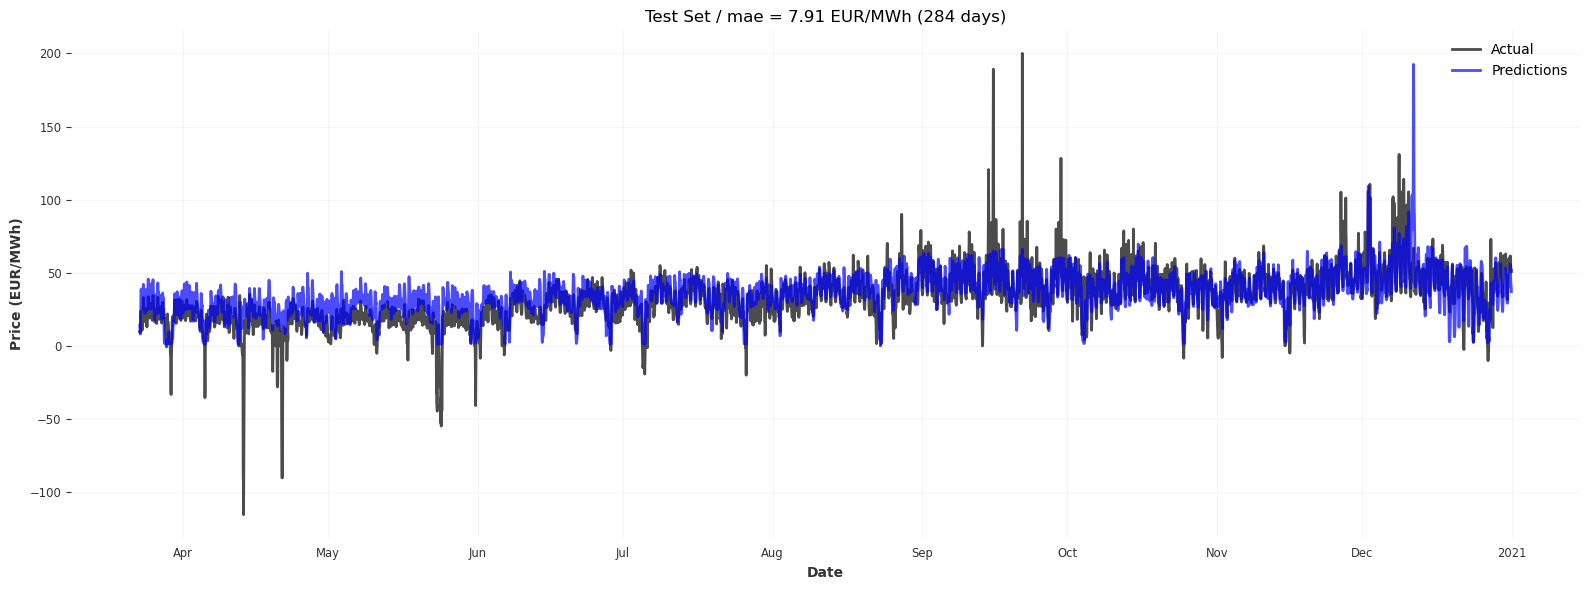

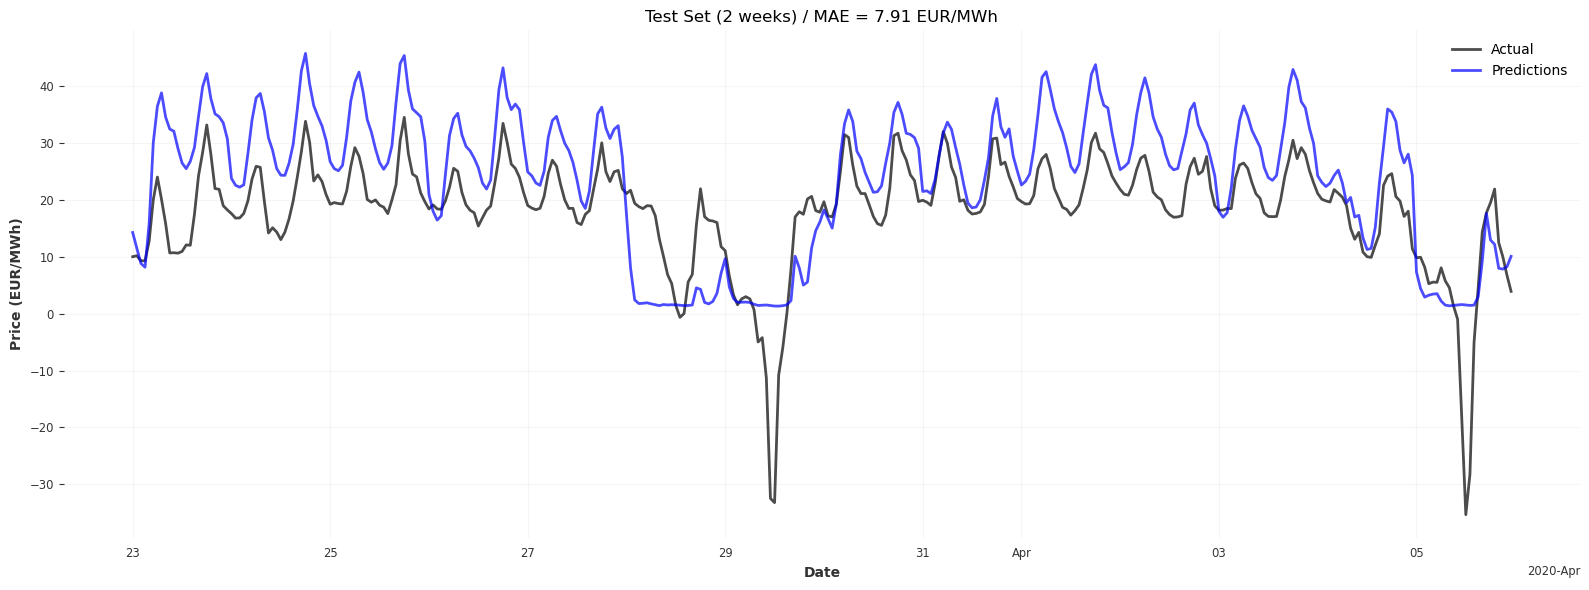

In [13]:
test_preds = final_model_v2.historical_forecasts(
    series=test_series,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    start=504+ 24,
    forecast_horizon=24,
    stride=24,
    retrain=False,
    verbose=True,
    last_points_only=False,
)

all_test_preds = concatenate(test_preds, axis=0)

pred_original = scaler_target.inverse_transform(all_test_preds).map(np.sinh)
actual_slice = test_series.slice(all_test_preds.start_time(), all_test_preds.end_time())
actual_original = scaler_target.inverse_transform(actual_slice).map(np.sinh)

n_days = len(test_preds)
mae_score = float(mae(actual_original, pred_original))
rmse_score = float(rmse(actual_original, pred_original))

print(f"mae : {mae_score:.2f}")
print(f"rmse : {rmse_score:.2f}")

plt.figure(figsize=(16, 6))
actual_original.plot(label="Actual", color="black", alpha=0.7)
pred_original.plot(label="Predictions", color="blue", alpha=0.7)
plt.title(f"Test Set / mae = {mae_score:.2f} EUR/MWh ({n_days} days)")
plt.ylabel("Price (EUR/MWh)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
actual_original[:336].plot(label="Actual", color="black", alpha=0.7)
pred_original[:336].plot(label="Predictions", color="blue", alpha=0.7)
plt.title(f"Test Set (2 weeks) / MAE = {mae_score:.2f} EUR/MWh")
plt.ylabel("Price (EUR/MWh)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import os
df_results = pd.DataFrame({
    'Actual': actual_original.values().flatten(),
    'Predicted': pred_original.values().flatten(),
}, index=actual_original.time_index)

df_results.index.name = 'Date'

full_path = os.path.join('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed', 'tft_forecast_results.csv')

os.makedirs('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed', exist_ok=True)
df_results.to_csv(full_path)